In [1]:
import torch

In [2]:
import os
os.chdir('../Downloads/')
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
sys.path.append('./lstm/')
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
data = np.load('npt_trajectory_sorted.npz')
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing

In [3]:
os.getcwd()

'/home/wenjie/Downloads'

In [4]:
atom_1_vx=data['arr_0'][1,:,5]

In [5]:
np.linspace(-3,3, num=20).tolist()

[-3.0,
 -2.6842105263157894,
 -2.3684210526315788,
 -2.0526315789473686,
 -1.736842105263158,
 -1.4210526315789473,
 -1.105263157894737,
 -0.7894736842105265,
 -0.47368421052631593,
 -0.1578947368421053,
 0.1578947368421053,
 0.4736842105263155,
 0.7894736842105261,
 1.1052631578947363,
 1.421052631578947,
 1.7368421052631575,
 2.052631578947368,
 2.3684210526315788,
 2.6842105263157894,
 3.0]

In [6]:
num_bins=20
sm_length=50
threshold=100

# x-values of the metastable states in the 4-state model potential.
X=np.linspace(-3,3,num=num_bins).tolist()

# Labels of all possible states in the ranges we considered.
# For 2d systems, this is not the same as the number of representative values.
all_combs = [i for i in range(num_bins)]
vocab=sorted(all_combs)
vocab_size = len(vocab)

char2idx = {u:i for i, u in enumerate(vocab)} # Mapping from characters to indices
idx2char = np.array(vocab)

# Sequence length and shift in step between past (input) & future (output)
seq_length = 100
shift=1

# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset.
BUFFER_SIZE = 50000

# Model parameters
embedding_dim = 8
rnn_units = 64

# Training epochs
EPOCHS=2

In [7]:
def running_mean(x, N):
    """
    Convolution as running average. Smoothen data.
    """
    return np.convolve(x, np.ones((N,))/N, mode='valid')

def find_nearest(key_arr, target):
    """
    key_arr: array-like, storing keys.
    target: the representative value which we want to be closest to.
    """
    idx=np.abs(key_arr-target).argmin()
    return idx

def Rm_peaks_steps(traj, threshold):
    """
    Remove sudden changes in the trajectory such as peaks and small steps.
    Here the gradient is used to identify the changes. If two nonzero
    gradients are too close (< threshold), we treat it as noise.
    """
    traj=np.array(traj)
    grad_traj=np.gradient(traj) # gradient of trajectory
    idx_grad=np.where(grad_traj!=0)[0] # the index of nonzero gradient.
    idx0=idx_grad[0]
    for idx in idx_grad:
        window=idx-idx0
        if window <= 1: # neighbor
            continue
        elif window > 1 and window <= threshold:
            traj[idx0:idx0+window//2+1]=traj[idx0]
            traj[idx0+window//2+1:idx+1]=traj[idx+1]
            idx0=idx
        elif window > threshold:
            idx0=idx
    return traj

def split_input_target(chunk):
    """
    split sequences into input and target.
    """
    input_text = chunk[:-shift]
    target_text = chunk[shift:]
    return input_text, target_text

In [8]:
scaler = preprocessing.StandardScaler()
scaler = scaler.fit(atom_1_vx.reshape(-1,1))

In [9]:
scaled_data = scaler.transform(atom_1_vx.reshape(-1,1))

In [10]:
input_x = running_mean(scaled_data.reshape(-1), sm_length)

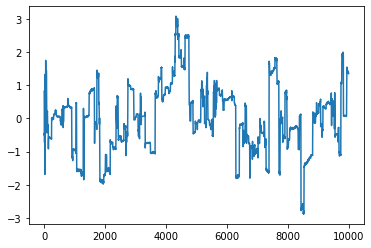

In [39]:
plt.plot(input_x[::10])

In [40]:
idx_x = map(lambda x : find_nearest(X, x), input_x)

In [41]:
idx_2d = list(idx_x)

In [42]:
text = idx_2d

In [43]:
idx_2d = Rm_peaks_steps(idx_2d, threshold)

In [44]:
text_as_int = np.array([char2idx[c] for c in text])

In [45]:
text = idx_2d

In [46]:
def convert2datalist(arr, seq_len):
    x=[]
    y=[]
    
    for i in range(len(arr)-seq_len):
        x_i = arr[i:i+seq_len]
        y_i = arr[i+1:i+seq_len+1]
        x.append(x_i)
        y.append(y_i)
    x_arr = np.array(x).reshape(-1, seq_len)
    y_arr = np.array(y).reshape(-1, seq_len)
    x_var = torch.autograd.Variable(torch.from_numpy(x_arr).float())
    y_var = torch.autograd.Variable(torch.from_numpy(y_arr).float())
    return x_var, y_var
        
    

In [47]:
x, y = convert2datalist(text, 1000)

In [48]:
"""x_onehot = torch.nn.functional.one_hot(x.to(torch.int64), num_classes=20)
y_onehot = torch.nn.functional.one_hot(y.to(torch.int64), num_classes=20)"""

'x_onehot = torch.nn.functional.one_hot(x.to(torch.int64), num_classes=20)\ny_onehot = torch.nn.functional.one_hot(y.to(torch.int64), num_classes=20)'

In [49]:
train_dataset = TensorDataset(torch.Tensor(x[::10][:-1000]).to(torch.int64),torch.Tensor(y[::10][:-1000]).to(torch.int64))
train_dataloader = DataLoader(train_dataset,batch_size = 128, shuffle = True)
test_dataset = TensorDataset(torch.Tensor(x[::10][-1000:]).to(torch.int64),torch.Tensor(y[::10][-1000:]).to(torch.int64))
test_dataloader = DataLoader(test_dataset,batch_size = 128, shuffle = False)

In [50]:
for a,b in train_dataloader:
    print(a.shape)
    print(b.shape)
    break

torch.Size([128, 1000])
torch.Size([128, 1000])


In [51]:
class RNN(torch.nn.Module):
    def __init__(self, index_size, hidden_size1, hidden_size2, output_size):
        super(RNN, self).__init__()
        self.emb = torch.nn.Embedding(index_size, hidden_size1)
        self.lstm = torch.nn.LSTM(hidden_size1, hidden_size2, dropout=0.2)
        
        self.fc = torch.nn.Linear(hidden_size2, output_size)
        self.softmax = torch.nn.Softmax(dim=-1)
        
    def forward(self, input):
        embed = self.emb(input)
        pred, (h,c) = self.lstm(embed)
        
        result = self.fc(pred)
        #result = self.softmax(result)
        return result, (h, c)
        
        
    

In [52]:
model = RNN(20,32,48,20)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/home/wenjie/anaconda3/envs/newtorch/lib/python3.8/site-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


RNN(
  (emb): Embedding(20, 32)
  (lstm): LSTM(32, 48, dropout=0.2)
  (fc): Linear(in_features=48, out_features=20, bias=True)
  (softmax): Softmax(dim=-1)
)

In [53]:

for a, b in train_dataloader:
    print(a.shape)
    print(b.shape)
    pred, _ = model(a.transpose(0,1).to(device))
    print(pred.shape)
    break
    

torch.Size([128, 1000])
torch.Size([128, 1000])
torch.Size([1000, 128, 20])


In [54]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)


In [55]:
#trian the model
epoches = 41

for epoch in range(epoches):
    model.train()
    LOSS = 0
    for x, y in train_dataloader:
        optimizer.zero_grad()
        x = x.to(torch.int64).transpose(0,1)
        x=x.to(device)
        y=y.to(torch.int64).transpose(0,1).to(device)
        
        pred, _ = model(x)
        
        loss = criterion(pred.reshape(-1,20), y.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),0.5)
        optimizer.step()
        LOSS = LOSS+loss
        
    print('current epoch is {:3d}, erros is {:5f}'.format(epoch, LOSS))
    
    if epoch%10 == 0:
        model.eval()
        with torch.no_grad():
            test_loss = 0
            for x, y in test_dataloader:
                x = x.to(torch.int64).transpose(0,1)
                x=x.to(device)
                y=y.to(torch.int64).transpose(0,1).to(device)

                pred, _ = model(x)

                loss = criterion(pred.reshape(-1,20), y.reshape(-1))

                test_loss +=loss
        
        print('current epoch is {:3d}, test erros is {:5f}'.format(epoch, test_loss))
    
        
        
        
        
        


current epoch is   0, erros is 203.750198
current epoch is   0, test erros is 22.009983
current epoch is   1, erros is 184.562119
current epoch is   2, erros is 160.839966
current epoch is   3, erros is 132.746735
current epoch is   4, erros is 105.633018
current epoch is   5, erros is 82.957603
current epoch is   6, erros is 65.112999
current epoch is   7, erros is 51.025757
current epoch is   8, erros is 40.564613
current epoch is   9, erros is 33.256020
current epoch is  10, erros is 28.061754
current epoch is  10, test erros is 2.852237
current epoch is  11, erros is 24.279015
current epoch is  12, erros is 21.298288
current epoch is  13, erros is 18.973240
current epoch is  14, erros is 17.028122
current epoch is  15, erros is 15.426154
current epoch is  16, erros is 14.080788
current epoch is  17, erros is 12.955556
current epoch is  18, erros is 11.981390
current epoch is  19, erros is 11.127217
current epoch is  20, erros is 10.391184
current epoch is  20, test erros is 1.34683

In [56]:
model.eval()
prediction = []
i, j = test_dataset[1]
i = i.unsqueeze(1).to(torch.int64).to(device)
with torch.no_grad():
    for m in range(10000):
        pred, _ = model(i)
        pred = model.softmax(pred)
        pred_id = torch.multinomial(pred[-1,0],1)
        
        
        prediction.append(pred_id)
        
        pred_id = pred_id.unsqueeze(1)
        
        i = torch.cat((i, pred_id), 0)[1:]
        
    

        



(array([  12.,    5.,   20., 1588., 2767., 4251., 1331.,   12.,    7.,
           7.]),
 array([ 0. ,  1.9,  3.8,  5.7,  7.6,  9.5, 11.4, 13.3, 15.2, 17.1, 19. ]),
 <BarContainer object of 10 artists>)

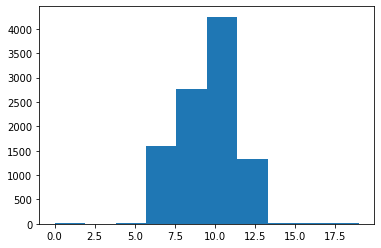

In [57]:
prediction = [i.cpu().numpy() for i in prediction]
prediction = np.array(prediction)
plt.hist(prediction)

(array([[173.,   0.,   0.,   0.,   0., 226.,   0.,   0.,   0., 601.],
        [174.,   0.,   0.,   0.,   0., 225.,   0.,   0.,   0., 601.]]),
 array([ 9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8, 11. ]),
 <a list of 2 BarContainer objects>)

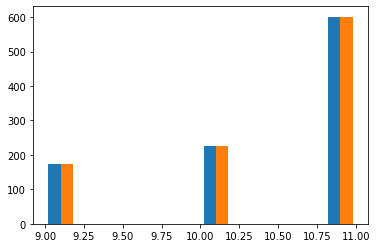

In [58]:
plt.hist(test_dataset[100])